## 🔗 Python & R Integration with .NET Interactive

In this section, I demonstrate how to connect Python and R kernels to the .NET Interactive system, allowing for seamless use of Python, R, and other languages together in a single notebook.

In [1]:
#!connect jupyter --kernel-name phd-python --conda-env phd --kernel-spec python3

The `#!connect jupyter` feature is in preview. Please report any feedback or issues at https://github.com/dotnet/interactive/issues/new/choose.

Kernel added: #!phd-python

In [50]:
#!connect jupyter --kernel-name Rkernel --conda-env phd --kernel-spec ir

The `#!connect jupyter` feature is in preview. Please report any feedback or issues at https://github.com/dotnet/interactive/issues/new/choose.

Kernel added: #!Rkernel

## 🐍 Python: Library Import and Global Variable Definition

In this section, I import my necessary libraries 📚 and define global variables 🌐 (mostly path-related). These variables can be reused throughout the code to adapt to different locations or users.

In [66]:
import os
import pandas as pd
import xarray as xr
import cftime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as ftr
from IPython.display import HTML
import numpy as np
from scipy.optimize import minimize
from statsmodels.base.model import GenericLikelihoodModel
import numpy as np
import pandas as pd
import warnings
from scipy import stats
import math
import numdifftools as nd
import statsmodels.api as sm
from scipy.optimize import approx_fprime
from scipy.stats import norm
from scipy.stats import chi2
import seaborn as sns

#Path to change !!!
DATA_PATH_PY = r"c:\Users\bobel\OneDrive - Université de Namur\Data"
DATA_PATH_R = "c:\\Users\\bobel\\OneDrive - Université de Namur\\Data"

GEV class

In [30]:
from EVT_Classes import * 

EOBS = pd.read_csv(r"c:\ThesisData\Blockmax\EOBS_blockmax.csv")

exog = {'scale':EOBS["tempanomalyMean"].values,'location':EOBS['tempanomalyMean'].values}
#initi_params = np.array([52, 0.1,12,0.1,0.07])
# Initialize and use EVTModel
model1 = GEVTradowsky(endog=EOBS["prmax"].values,exog=exog,full_output=True)
a = model1.fit()
print(a)


          EVT Results Summary       
AIC: 646.70
BIC: 651.34

-----------------------------------------------------------------
Parameter  Estimate   SE     z     P>|z|  95% CI          Signif.
-----------------------------------------------------------------
1          6.5034     3.5598  1.83   0.0677  (-0.4737, 13.4806) 
2          -0.1897    0.3371  -0.56  0.5736  (-0.8504, 0.4710) 
-----------------------------------------------------------------
Notes: *** p<0.001, ** p<0.01, * p<0.05



## 🧩 Function Corpus

In this section, I define my python functions for later use. All functions are well-documented with descriptions, and examples are provided for each function to illustrate how they work.

### 🛠️ Section 1: Masking Functions

This section contains specialized functions for cropping space-time datacubes, either in time, space, or both. These functions are essential for handling smaller datasets and making data manipulation more efficient.

In [43]:
def mask_square(ds, center, side_length):
    """
    Masks the dataset to include only points within a specified square.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing latitude and longitude data.
    center (tuple): A tuple of coordinates (longitude, latitude) representing the center of the square.
    side_length (float): The side length of the square in degrees.

    Returns:
    xarray.Dataset: A new xarray dataset containing only the points within the specified square.
    """

    ds = ds.copy()
    # Calculate the half side length
    half_side = side_length / 2

    # Define the boundaries of the square
    min_lon = center[0] - side_length
    max_lon = center[0] + side_length
    min_lat = center[1] - side_length
    max_lat = center[1] + side_length

    # Apply the mask to select points within the square
    masked_ds = ds.where((ds['lon']>min_lon )&(ds['lon']< max_lon)&(ds['lat']<max_lat)&(ds['lat']>min_lat),drop = True)
    return masked_ds

def mask_time(ds, season='summer'):
    """
    Mask the dataset to include only specific seasons, such as summer (April to September) or winter (October to March).

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing a time dimension with cftime objects.
    season (str, optional): The season to mask. Supports 'summer' (April to September) or 'winter' (October to March). Default is 'summer'.

    Returns:
    xarray.Dataset: A new xarray dataset containing only the specified season.

    Example usage:
    ds_summer = mask_time(datacube, season='summer')
    ds_winter = mask_time(datacube, season='winter')
    """
    if season == 'summer':
        ds = ds.sel(time=[t for t in ds['time'].values if t.month in [4, 5, 6, 7, 8, 9]])
    elif season == 'winter':
        ds = ds.sel(time=[t for t in ds['time'].values if t.month in [10, 11, 12, 1, 2, 3]])
    else:
        raise ValueError("Supported seasons are 'summer' and 'winter'.")
    return ds

### 📂 Loading Section: DataCube Loading Functions

This section is specialized in loading space-time datacubes from various file formats, such as NetCDF, while applying the masks built in **Section 1**. These masks help reduce the dataset size by cropping the datacube in time, space, or both, making it more efficient to work with and easier to manipulate.


In [44]:
def convert_360_to_180(values):
        return xr.where(values < 180, values, values - 360)

def load_netcdf(filepath, coords=('pr','lat','lon'), use_cftime=True):
    """
    Load a NETCDF file and return it as an xarray dataset.

    Parameters:
    filepath (str): Path to the NETCDF file to be loaded.
    use_cftime (bool): Whether to use cftime for handling dates out of numpy range. Default is True.
    Returns:
    xarray.Dataset: The loaded dataset.
    """
    try:
        dataset = xr.open_dataset(filepath, engine='netcdf4', use_cftime=use_cftime)
        coord_names = list(dataset.coords.keys())
        datavars_names = list(dataset.data_vars.keys())
        if 'pr' not in datavars_names:
            dataset = dataset.rename({coords[0]: 'pr'})
            dataset['pr'].attrs['units'] = 'mm/day'
        else:
            dataset['pr'] = dataset['pr'] * 86400
            dataset['pr'].attrs['units'] = 'mm/day'
        if 'lat' not in coord_names:
            dataset = dataset.rename({coords[1]: 'lat'})
        if 'lon' not in coord_names:
            dataset = dataset.rename({coords[2]: 'lon'})
        return dataset
    except FileNotFoundError:
        print(f"Error: The file at '{filepath}' was not found.")
    except ImportError:
        print("Error: Required dependencies for reading NETCDF files are not installed. Please refer to https://docs.xarray.dev/en/stable/getting-started-guide/installing.html")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
# ds = load_netcdf('path/to/netcdf_file.nc')
# print(ds)

def assemble_datacube(folderpath, crop=(True,(4.4699, 50.5039),6,'summer'), max_files=100):
    """
    Assemble a datacube along the time dimension from multiple NETCDF files in a folder until a certain maximum number of files is reached.
    
    Parameters:
    folderpath (str): Path to the folder containing NETCDF files.
    max_files (int, optional): The maximum number of NETCDF files to read for the assembled datacube. Default is 100.

    Returns:
    xarray.Dataset: The assembled datacube.
    """
    
    datacube = None  # Initialize an empty datacube to concatenate into
    file_count = 0

    try:
        for filename in os.listdir(folderpath):
            if filename.endswith(".nc"):
                filepath = os.path.join(folderpath, filename)
                if crop[0]:
                    ds = mask_time(mask_square(load_netcdf(filepath), crop[1], crop[2]),'summer')
                else:
                    ds = load_netcdf(filepath)
                if datacube is None:
                    datacube = ds  # Initialize the datacube
                else:
                    datacube = xr.concat([datacube, ds], dim='time')  # Concatenate along time dimension
                file_count += 1
                if file_count >= max_files:
                    break

        if datacube is not None:
            datacube['lon'] = convert_360_to_180(datacube['lon'])  # Convert longitudes if needed
            datacube = datacube.sortby(['lat', 'lon'])  # Sort by lat and lon
            return datacube
        else:
            print("No valid NETCDF files found in the folder.")
    except Exception as e:
        print(f"An error occurred while assembling the datacube: {e}")

# Example usage:
# datacube = assemble_datacube('path/to/folder')
# print(datacube)


### 🎨 Plotting Section: Static and Dynamic Visualization Functions

This section focuses on plotting data either statically or dynamically using animations in **Matplotlib**. The functions in this section use the loaded data from **Section 2** and allow users to visualize the masks applied in **Section 1**, both in time and space. These visualizations are powerful tools to ensure the data is well-conditioned in both dimensions and provide insightful visual analysis.

#### 📊 Static Plots:
- Visualize data at specific time steps or spatial regions.
- Check how masks affect the data over time or space.

#### 🎞️ Dynamic Plots (Animations):
- Create time-lapse visualizations to observe temporal evolution.
- Useful for understanding changes in datasets across multiple time frames.

In [45]:
def plot_datacube(ds, variable='pr', time_step=0, ax=None, cbar_ax=None, fig=None, figsize=(10, 5), norm=None, interpolation=None, cmap='Blues'):
    """
    Plot a single time step of the datacube for a specified variable, or just the data if no time dimension exists.

    Parameters:
    ds (xarray.Dataset): The dataset containing the data to be plotted.
    variable (str, optional): The name of the variable to plot. Default is 'pr'.
    time_step (int, optional): The time step to plot. Default is 0.
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis to plot on. Default is None.
    cbar_ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis for the colorbar. Default is None.
    fig (matplotlib.figure.Figure, optional): Figure object for adding the colorbar. Default is None.
    figsize (tuple, optional): Figure size. Default is (10, 5).
    norm (optional): Normalization for color mapping. Default is None.
    interpolation (str, optional): Interpolation method for imshow. Default is None.
    cmap (str or Colormap, optional): Colormap for the plot. Default is 'Blues'.
    """
    if ax is None or cbar_ax is None or fig is None:
        gs = GridSpec(1, 2, width_ratios=[1, 0.05])
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
        cbar_ax = fig.add_subplot(gs[1])

    # Check if the variable exists in the dataset
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    # Check if the dataset has a time dimension and select the data accordingly
    if 'time' in ds.dims:
        data = ds[variable].isel(time=time_step)
        title = f"{variable.upper()} Plot for Date: {str(ds.time.values[time_step])}"
    else:
        data = ds[variable]
        title = f"{variable.upper()} Plot"

    # Plot the data
    img = ax.imshow(data, origin='upper', transform=ccrs.PlateCarree(), cmap=cmap,
                    extent=[ds['lon'].min(), ds['lon'].max(), ds['lat'].min(), ds['lat'].max()],
                    interpolation=interpolation, norm=norm)  # Allow selection of interpolation and colormap
    ax.coastlines()
    ax.add_feature(ftr.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    ax.set_title(title)

    # Update colorbar with the variable's name and units (default to 'unknown units' if not provided)
    units = ds[variable].attrs.get('units', 'unknown units')
    fig.colorbar(img, ax=ax, cax=cbar_ax, shrink=0.5, aspect=5, label=f"{variable} ({units})")

    if ax is None or cbar_ax is None or fig is None:
        plt.show()

#global_min, global_max = CMISP_summer['pr'].min(), CMISP_summer['pr'].quantile(0.975)
#norm = colors.Normalize(vmin=global_min, vmax=global_max)
#plot_datacube(CMISP_summer, figsize = (8,6),norm=norm)
def animate_datacube(ds, variable='pr', time_range=10, norm=None, interpolation=None, cmap='Blues'):
    """
    Create an animation of the datacube over the time dimension for a specified variable.

    Parameters:
    ds (xarray.Dataset): The dataset containing the data to be animated.
    variable (str, optional): The name of the variable to animate. Default is 'pr'.
    time_range (int, optional): The number of time steps to animate. Default is 10.
    norm (optional): Normalization for color mapping. Default is None.
    interpolation (str, optional): Interpolation method for imshow. Default is None.
    cmap (str or Colormap, optional): Colormap for the animation. Default is 'Blues'.
    """
    # Set up the figure and axis
    gs = GridSpec(1, 2, width_ratios=[0.9, 0.05])
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    cbar_ax = fig.add_subplot(gs[1])

    # Update function for animation
    def update(frame):
        ax.clear()
        plot_datacube(ds, variable=variable, time_step=frame, ax=ax, cbar_ax=cbar_ax, fig=fig, norm=norm, interpolation=interpolation, cmap=cmap)

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=min(time_range, ds.dims.get('time', 1)), interval=500)
    plt.rcParams['animation.embed_limit'] = 50  # Set embed limit to 50 MB
    return HTML(ani.to_jshtml())


### Processing functions

In [104]:
def save_tempanomaly(ds, filepath, blockpath, start_year='1950-01-01', end_year='2024-12-31'):
    """
    Calculate the annual mean temperature anomaly from the given dataset and save it as a CSV file.

    Parameters:
    ds (xarray.Dataset): The dataset containing the temperature anomaly data ('tempanomaly').
    filepath (str): The path to save the resulting CSV file.
    start_year (str, optional): The start year for the data to be considered. Default is '1950-01-01'.
    end_year (str, optional): The end year for the data to be considered. Default is '2024-12-31'.

    Returns:
    pandas.DataFrame: A DataFrame with years and mean temperature anomalies.

    Example usage:
    save_tempanomaly(GISTEMP, 'output/annual_mean_tempanomaly.csv')
    """
    # Filter the dataset to only include years between start_year and end_year
    ds_filtered = ds.sel(time=slice(start_year, end_year))
    
    # Resample the data to an annual frequency and calculate the mean for each year across 'lat' and 'lon'
    annual_mean_tempanomaly = ds_filtered['tempanomaly'].resample(time='1Y').mean(dim=['time', 'lat', 'lon']).to_dataframe().reset_index()
    
    # Extract the year from the time column and create a 'year' column
    annual_mean_tempanomaly['year'] = annual_mean_tempanomaly['time'].apply(lambda x: x.year)
    annual_mean_tempanomaly = annual_mean_tempanomaly[['year', 'tempanomaly']]
    annual_mean_tempanomaly.rename(columns={'tempanomaly': 'tempanomalyMean'}, inplace=True)
    
    # Check if the Blockmax CSV file exists
    blockmax_filepath = blockpath
    if not os.path.exists(blockmax_filepath):
        raise FileNotFoundError(f"The file '{blockmax_filepath}' was not found.")
    
    # Load the Blockmax DataFrame and merge with the annual mean temperature anomaly DataFrame
    blockmax_df = pd.read_csv(blockmax_filepath)
    merged_df = pd.merge(blockmax_df, annual_mean_tempanomaly, on='year')
    
    # Save the resulting DataFrame as a CSV file
    merged_df.to_csv(filepath, index=False)
    
    return merged_df

### 📊 EVT Analysis Section: Block Maxima and Peak Over Threshold

This section focuses on transforming the data to correspond with the two main philosophies of Extreme Value Theory (EVT): **Block Maxima** and **Peak Over Threshold (POT)**. These transformations help prepare the data for EVT analysis, which is crucial for studying extreme events.

#### 🌐 EVT Techniques:
1. **Block Maxima**: Divides the dataset into blocks (e.g., yearly or monthly) and retains only the maximum value from each block, allowing for the analysis of extreme values within those blocks.
2. **Peak Over Threshold (POT)**: Focuses on values that exceed a predefined threshold, retaining all data points that represent extremes beyond that threshold.

In [46]:
def block_maximum(ds):
    """
    Calculate the maximum precipitation value per year over all spatial dimensions and time jointly, and return a pandas DataFrame.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing the precipitation data ('pr'). The dataset should be masked in space and time.

    Returns:
    pandas.DataFrame: A DataFrame with years as the index and maximum precipitation values as the column.

    Example usage:
    df_max_precip = block_maximum(ds_summer)
    """
    # Resample the dataset to annual frequency and take the maximum value for each year over all dimensions (time, lat, lon)
    annual_max = ds['pr'].resample(time='1Y').max(dim=['time', 'lat', 'lon'])
    # Create a DataFrame from the resampled data
    df_max_precip = annual_max.to_dataframe().reset_index()
    # Extract only the year from the time column
    df_max_precip['year'] = df_max_precip['time'].apply(lambda x: x.year)
    df_max_precip = df_max_precip[['year', 'pr']]
    df_max_precip.rename(columns={'pr': 'prmax'}, inplace=True)
    return df_max_precip

### 💾 Export Section: Export Processed Data to CSV

This section handles the export of processed data, such as the results from the EVT analysis, to CSV format for further use or sharing. This ensures that the processed data is stored in a widely compatible format, allowing for easy access and use outside the current environment.

In [98]:
def export_csv(df, filepath, overwrite=True):
    """
    Export a pandas DataFrame to a CSV file. Allows overwriting if the file already exists.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be exported.
    filepath (str): The path where the CSV file will be saved.
    overwrite (bool, optional): Whether to overwrite the file if it already exists. Default is True.

    Example usage:
    export_csv(df_max_precip, 'output/max_precipitation.csv')
    """
    import os
    if os.path.exists(filepath) and not overwrite:
        raise FileExistsError(f"The file '{filepath}' already exists and overwrite is set to False.")
    df.to_csv(filepath, index=False)


filepath = r"c:\Users\bobel\Downloads\pr_day_EC-Earth3_piControl_r1i1p1f1_gr_22590101-22591231.nc"
#export_csv(CMISP_blockmax,filepath)

### 🛠️ Practical Section: Applying the Function Corpus to Process Data
In this section, we demonstrate how to use the function corpus to process various datasets from start to finish. This includes loading the data, applying space-time masks, performing EVT analysis, visualizing the data, and exporting the processed results.

#### 🔄 Step-by-Step Workflow (example):

1. **Load the Data**: We first load the dataset (e.g., a space-time datacube) using the functions from the **Loading Section**.
2. **Apply Masks**: Next, we crop the dataset spatially, temporally, or both using the masking functions from **Section 1**.
3. **EVT Analysis**: After masking, we transform the data using the **Block Maxima** or **Peak Over Threshold** methods from the **EVT Section**.
4. **Visualize the Data**: Before finalizing the analysis, we create both static and dynamic visualizations using the **Plotting Section** functions to ensure the data is properly conditioned.
5. **Export the Data**: Finally, we export the processed data to CSV format for external use or storage using the **Export Section** function.

### CMISP Data

In [ ]:
CMISP_summer = assemble_datacube(folderpath=r"c:\ThesisData\CMISP",max_files=100)
global_min = EOBS_summer['pr'].min()
global_max = EOBS_summer['pr'].quantile(0.975)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
animate_datacube(EOBS_summer.sel(time=slice(EOBS_summer.time[-60], EOBS_summer.time[-1])), time_range=3,norm=norm)
CMISP_blockmax = block_maximum(CMISP_summer)
CMISP_blockmax


### EOBS Data

In [134]:
center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 1.5  # Side length of the square in degrees
EOBS_summer = mask_time(
    mask_square(
        load_netcdf(filepath=r"c:\ThesisData\E_OBS\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
        center_coordinates,
        side_length
    ),
    season='summer'
)

### GISTEMP Data

In [ ]:
GISTEMP = xr.open_dataset(r"c:\Users\bobel\Downloads\gistemp1200_GHCNv4_ERSSTv5.nc", engine='netcdf4')
GISTEMP
save_tempanomaly(GISTEMP,r"c:\Users\bobel\Downloads\UCL_blockmax.csv",r"c:\Users\bobel\Downloads\UCL_blockmax.csv")


### Uccles Data

In [24]:
df = pd.read_csv(r"c:\Users\bobel\OneDrive - Université de Namur\Data\UCCLES\Precip_Uccle_1892.csv")
df['DAY'] = pd.to_datetime(df['DAY'])
df['year'] = df['DAY'].dt.year
# Group by year and calculate the max precipitation for each year
max_precip_per_year = df.groupby('year')['PRECIP_QUANTITY'].max().reset_index()
max_precip_per_year
export_csv(filepath=r"c:\Users\bobel\OneDrive - Université de Namur\Data\Blockmax\UCL_blockmax.csv",df=max_precip_per_year)

Model Comparison

1. **Stationary**: No covariate dependence.
   - $ \mu $, $ \sigma $, $ \xi $ are constant.

2. **Loc-linear**: Linear dependence on location.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma $, $ \xi $

3. **Loc+Shape-linear**: Linear dependence on location and shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = \alpha_0 + \alpha_0 x_1 $, $ \xi $

4. **Loc+Scale+Shape-linear**: Linear dependence on location, scale, and shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = \alpha_0 + \alpha_1 x_1 $, $ \xi = \gamma_0 + \gamma_1 x_1 $

5. **Stationary (scale exp link)**: Stationary model with an exponential link on shape.
   - $ \mu $, $ e^{\alpha_0} $, $ \xi $

6. **Loc-linear (scale exp link)**: Linear dependence on location with an exponential link on shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $\sigma = e^{\alpha_0}$, $ \xi $

7. **Loc+Shape-linear (scale exp link)**: Linear dependence on location and shape, with an exponential link on shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = e^{\alpha_0 + \alpha_1 x_1} $, $ \xi$

8. **Loc+Scale+Shape-linear (scale exp link)**: Linear dependence on location, scale, and shape, with an exponential link on shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = e^{\alpha_0 + \alpha_1 x_1} $, $ \xi = \gamma_0 + \gamma_1 x_1 $

In [132]:
EOBS = pd.read_csv(r"c:\ThesisData\OUTPUTS\UCL_blockmax.csv")
exog1 = {}
exog2 = {'location':EOBS['tempanomalyMean']}
exog3 = {'location':EOBS['tempanomalyMean'],
'scale' : EOBS['tempanomalyMean']}
exog4 = {'location':EOBS['tempanomalyMean'],
'shape' : EOBS['tempanomalyMean'], 'scale': EOBS['tempanomalyMean']}
exog5 = {'location':EOBS['tempanomalyMean'].values,
'scale' : EOBS['tempanomalyMean'].values}
fit1 = GEV(endog=EOBS["prmax"],exog=exog1,full_output=True).fit()
fit2 = GEV(endog=EOBS["prmax"],exog=exog2,full_output=True).fit()
fit3 = GEV(endog=EOBS["prmax"],exog=exog3,full_output=True).fit()
fit4 = GEV(endog=EOBS["prmax"],exog=exog4,full_output=True).fit()
fit5 = GEV(endog=EOBS["prmax"],exog=exog,scale_link=EVTModel.exp_link,full_output=True).fit()
fit6 = GEV(endog=EOBS["prmax"],exog=exog2,scale_link=EVTModel.exp_link, full_output=True).fit()
fit7 = GEV(endog=EOBS["prmax"],exog=exog3,scale_link=EVTModel.exp_link, full_output=True).fit()
fit8 = GEV(endog=EOBS["prmax"],exog=exog4,scale_link=EVTModel.exp_link, full_output=True).fit()
fit9 = GEVTradowsky(endog=EOBS["prmax"].values,exog=exog5, full_output=True).fit()

import pandas as pd
# Assuming each fit object has .AIC() and .BIC() methods
# Replace these calls with the actual AIC and BIC values from your model fits
data = {
    "Model Name": [
        "Stationary",
        "Loc-linear",
        "Loc+scale-linear",
        "Loc+Scale+Shape-linear",
        "Stationary",
        "Loc-linear",
        "Loc+exp(Scale)-linear",
        "Loc+exp(Scale)+Shape-linear",
        "Tradowsky model"
    ],
    "AIC": [fit1.AIC(), fit2.AIC(), fit3.AIC(), fit4.AIC(), fit5.AIC(), fit6.AIC(), fit7.AIC(), fit8.AIC(),fit9.AIC()],
    "BIC": [fit1.BIC(), fit2.BIC(), fit3.BIC(), fit4.BIC(), fit5.BIC(), fit6.BIC(), fit7.BIC(), fit8.BIC(),fit9.BIC()]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Use pandas Styler to format the table nicely
styled_df = df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]}
]).format(precision=2).set_properties(**{
    'text-align': 'center',
    'font-family': 'Arial, sans-serif',
    'border-collapse': 'collapse'
}).set_caption("Model Comparison: AIC and BIC Scores")

styled_df

,Model Name,AIC,BIC
0,Stationary,621.52,628.47
1,Loc-linear,615.19,624.46
2,Loc+scale-linear,617.19,628.77
3,Loc+Scale+Shape-linear,618.15,632.05
4,Stationary,617.13,628.72
5,Loc-linear,615.19,624.46
6,Loc+exp(Scale)-linear,617.19,628.77
7,Loc+exp(Scale)+Shape-linear,618.12,632.03
8,Tradowsky model,615.23,619.87


In [133]:
print("LINEAR LOCATION MODEL")
print(fit1)
print("TRADOWSKY MODEL")
print(fit9)

LINEAR LOCATION MODEL

          EVT Results Summary       
AIC: 621.52
BIC: 628.47

-----------------------------------------------------------------
Parameter  Estimate   SE     z     P>|z|  95% CI          Signif.
-----------------------------------------------------------------
1          55.8989    5.1306  10.90  0.0000  (45.8429, 65.9549) ***
2          12.3202    3.6188  3.40   0.0007  (5.2273, 19.4131) ***
3          0.0250     0.1136  0.22   0.8261  (-0.1976, 0.2476) 
-----------------------------------------------------------------
Notes: *** p<0.001, ** p<0.01, * p<0.05

TRADOWSKY MODEL

          EVT Results Summary       
AIC: 615.23
BIC: 619.87

-----------------------------------------------------------------
Parameter  Estimate   SE     z     P>|z|  95% CI          Signif.
-----------------------------------------------------------------
1          5.6877     2.6301  2.16   0.0306  (0.5327, 10.8426) *
2          -0.0085    0.0878  -0.10  0.9233  (-0.1806, 0.1636) 
-----

Parameters map (location, scale, shape, alpha {Tradowsky})

In [52]:
center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 2  # Side length of the square in degrees
EOBS_summer = mask_square(mask_time(load_netcdf(filepath=r"c:\ThesisData\E_OBS\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
'summer'),center_coordinates,side_length)
EOBS_summer

<xarray.Dataset>
Dimensions:  (time: 13633, lat: 40, lon: 40)
Coordinates:
  * lat      (lat) float64 48.55 48.65 48.75 48.85 ... 52.15 52.25 52.35 52.45
  * lon      (lon) float64 5.05 5.15 5.25 5.35 5.45 ... 8.55 8.65 8.75 8.85 8.95
  * time     (time) object 1950-04-01 00:00:00 ... 2024-06-30 00:00:00
Data variables:
    pr       (time, lat, lon) float32 4.4 4.1 4.5 4.0 ... 11.7 14.8 16.2 16.9
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:04:01 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....

In [53]:
def block_maximum_grid(ds): 
    """
    Calculate the maximum precipitation value per year for each pixel individually and return an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing the precipitation data ('pr').

    Returns:
    xarray.Dataset: A Dataset with yearly maximum precipitation values for each pixel.
    """
    # Resample the dataset to annual frequency and take the maximum value for each year over the time dimension only
    annual_max = ds['pr'].resample(time='1Y').max(dim='time')
    annual_max_ds = annual_max.to_dataset(name='pr')
    
    # The result is an xarray Dataset with the maximum precipitation per year for each lat-lon pixel
    return annual_max_ds

EOBS_blockmax_grid = block_maximum_grid(EOBS_summer)
global_min = EOBS_blockmax_grid['pr'].min()
global_max = EOBS_blockmax_grid['pr'].quantile(0.975)
norm = colors.Normalize(vmin=global_min, vmax=global_max)

In [81]:
def fit_gev_model(ds, exog={}):
    """
    Fit a GEV model to each spatial pixel's time series of prmax values and store the results in an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing the annual maximum precipitation ('prmax') for each pixel.
    exog (array-like): The exogenous variables used in the GEV model.

    Returns:
    xarray.Dataset: A Dataset containing the fitted parameters for each spatial pixel.
    """
    # Initialize arrays to store the model parameters for each pixel
    shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    scale_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    
    # Loop over each spatial pixel
    for i, lat in enumerate(ds['lat'].values):
        for j, lon in enumerate(ds['lon'].values):
            # Extract the time series for the current pixel
            prmax_series = ds['pr'].sel(lat=lat, lon=lon).values
            
            # Check if the time series is valid (e.g., not all NaNs)
            if np.any(~np.isnan(prmax_series)):
                # Fit the GEV model
                model = GEV(endog=prmax_series, exog=exog, full_output=True)
                fit_result = model.fit()
                
                # Store the fitted parameters
                location_param[i, j] = fit_result.like.x[0]
                shape_param[i, j] = fit_result.like.x[1]
                scale_param[i, j] = fit_result.like.x[2]

    # Create a Dataset to store the fitted parameters
    fitted_params_ds = xr.Dataset(
        {
            'shape': (['lat', 'lon'], shape_param),
            'location': (['lat', 'lon'], location_param),
            'scale': (['lat', 'lon'], scale_param)
        },
        coords={
            'lat': ds['lat'],
            'lon': ds['lon']
        }
    )
    
    return fitted_params_ds

EOBS_gev_grid = fit_gev_model(EOBS_blockmax_grid)
EOBS_gev_grid

<xarray.Dataset>
Dimensions:   (lat: 40, lon: 40)
Coordinates:
  * lat       (lat) float64 48.55 48.65 48.75 48.85 ... 52.15 52.25 52.35 52.45
  * lon       (lon) float64 5.05 5.15 5.25 5.35 5.45 ... 8.65 8.75 8.85 8.95
Data variables:
    shape     (lat, lon) float64 6.727 6.888 6.584 6.544 ... 5.021 6.362 6.085
    location  (lat, lon) float64 24.49 25.21 24.13 24.06 ... 21.2 21.84 22.04
    scale     (lat, lon) float64 0.1863 0.127 0.1881 ... 0.4855 0.1724 0.2259

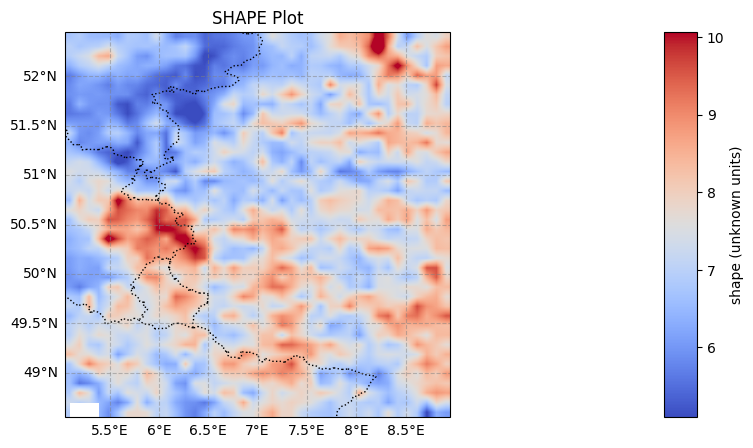

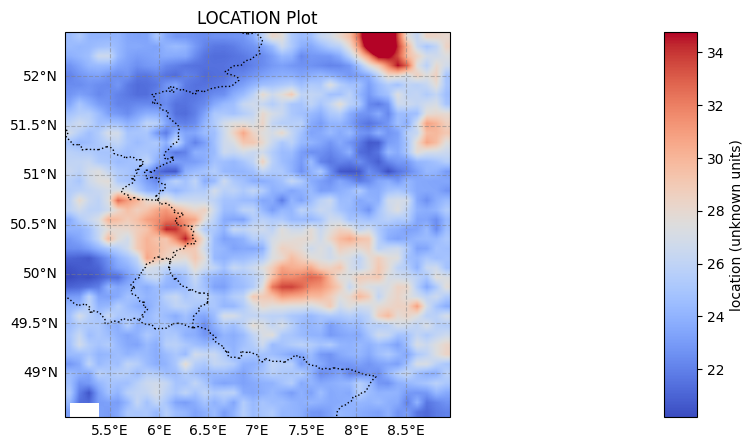

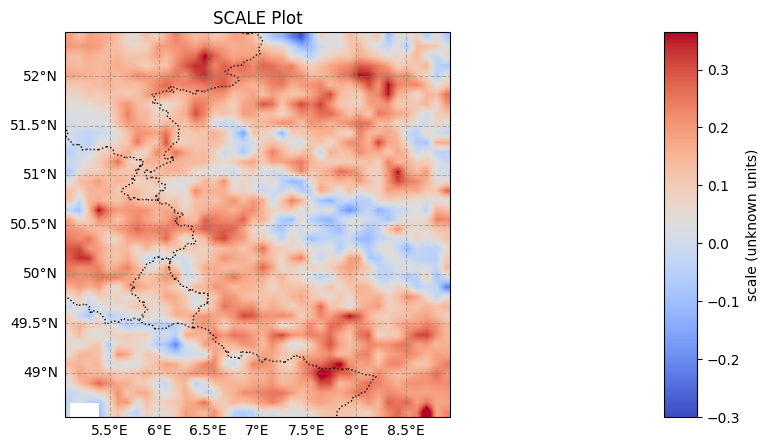

In [62]:
global_min = EOBS_gev_grid['shape'].quantile(0.005)
global_max = EOBS_gev_grid['shape'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_grid,variable='shape',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = EOBS_gev_grid['location'].min()
global_max = EOBS_gev_grid['location'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_grid,variable='location',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = -0.3
global_max = EOBS_gev_grid['scale'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_grid,variable='scale',cmap='coolwarm',norm=norm,interpolation='bilinear')

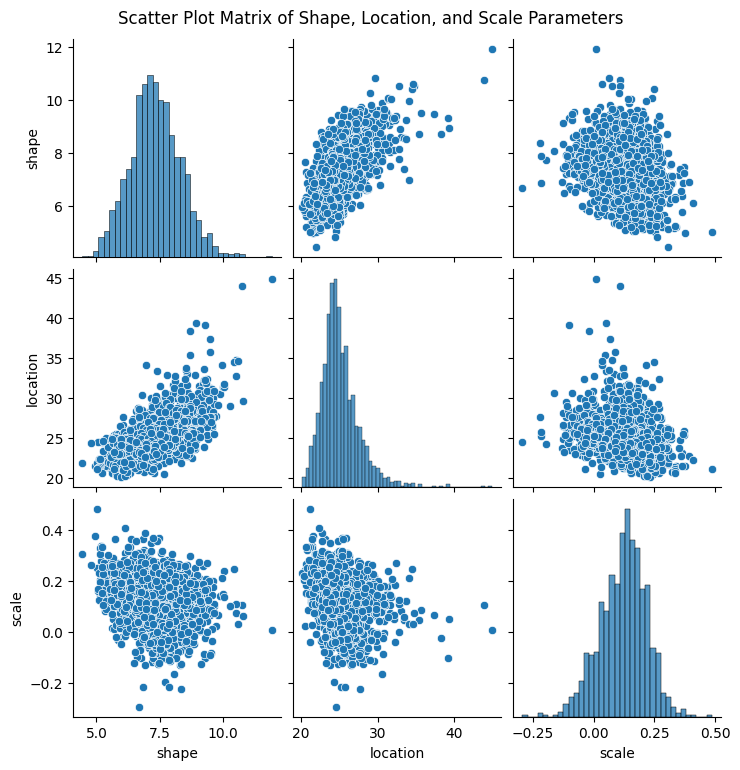

In [84]:
df = EOBS_gev_grid.to_dataframe().reset_index()

# Plot pairwise scatter plots for 'shape', 'location', and 'scale'
sns.pairplot(df, vars=['shape', 'location', 'scale'], kind='scatter')
plt.suptitle("Scatter Plot Matrix of Shape, Location, and Scale Parameters", y=1.02)
plt.show()

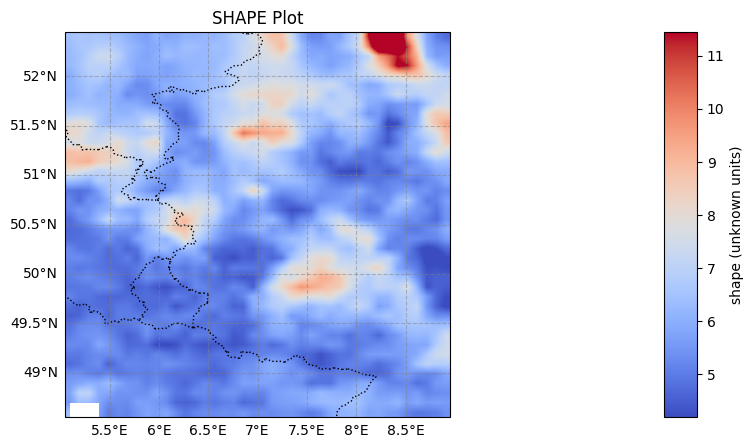

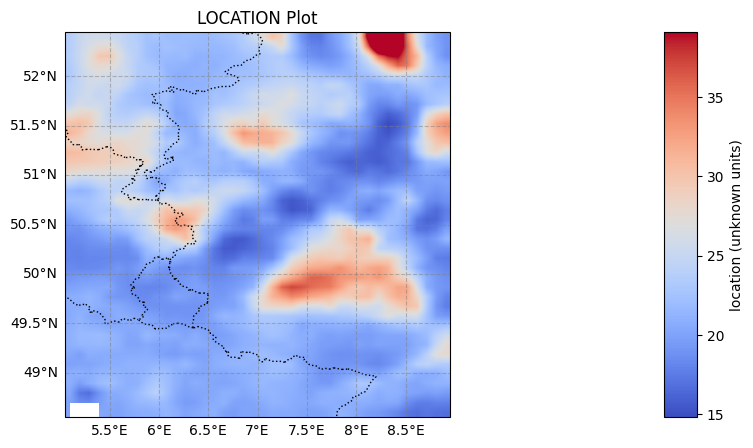

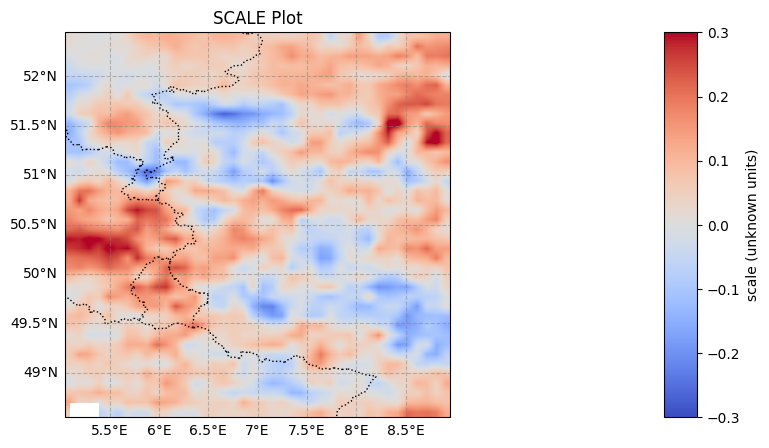

In [148]:
center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 2  # Side length of the square in degrees
EOBS_gev_large_w = fit_gev_model(block_maximum_grid(mask_time(
    mask_square(
        load_netcdf(filepath=r"c:\ThesisData\E_OBS\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
        center_coordinates,
        side_length
    ),
    season='winter'
)))
global_min = EOBS_gev_large_w['shape'].quantile(0.005)
global_max = EOBS_gev_large_w['shape'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large_w,variable='shape',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = EOBS_gev_large_w['location'].min()
global_max = EOBS_gev_large_w['location'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large_w,variable='location',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = -0.3
global_max = EOBS_gev_large_w['scale'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large_w,variable='scale',cmap='coolwarm',norm=norm,interpolation='bilinear')

In [97]:
center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 15  # Side length of the square in degrees
EOBS_gev_large = fit_gev_model(block_maximum_grid(mask_time(
    mask_square(
        load_netcdf(filepath=r"c:\ThesisData\E_OBS\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
        center_coordinates,
        side_length
    ),
    season='summer'
)))

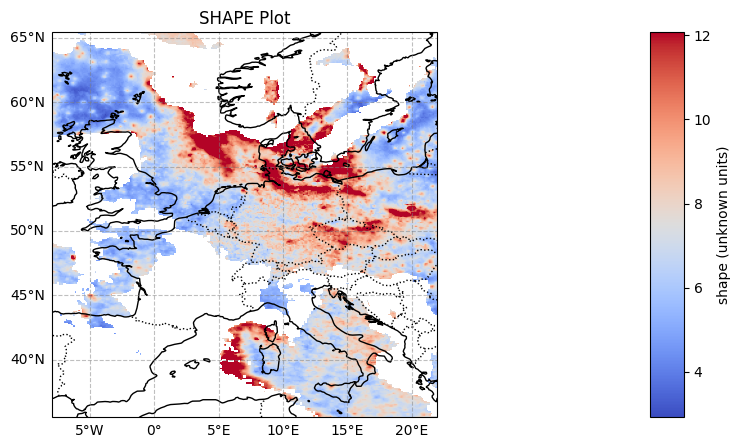

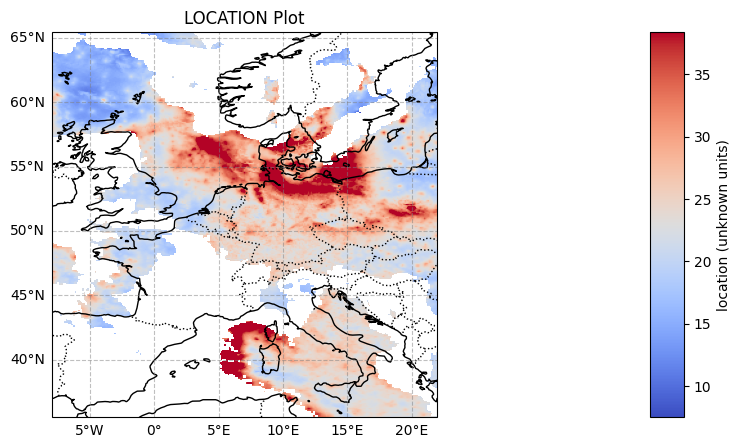

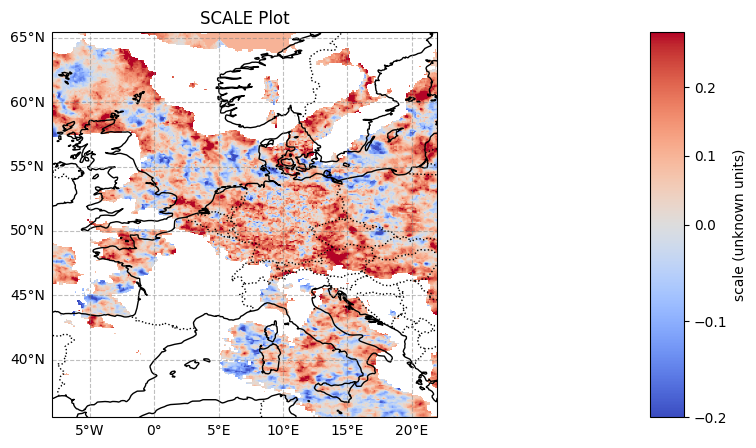

In [152]:
global_min = EOBS_gev_large['shape'].min()
global_max = EOBS_gev_large['shape'].quantile(0.95)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large,variable='shape',cmap='coolwarm',norm=norm)
global_min = EOBS_gev_large['location'].min()
global_max = EOBS_gev_large['location'].quantile(0.95)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large,variable='location',cmap='coolwarm',norm=norm)
global_min = -0.2
global_max = EOBS_gev_large['scale'].quantile(0.975)
norm = colors.TwoSlopeNorm(vmin=global_min, vcenter=0, vmax=global_max)
plot_datacube(EOBS_gev_large,variable='scale',cmap='coolwarm',norm=norm)

In [129]:
EOBS = pd.read_csv(r"c:\ThesisData\OUTPUTS\UCL_blockmax.csv")
def fit_gevTradowsky_model(ds, exog={'location':EOBS['tempanomalyMean'].values, 'scale':EOBS['tempanomalyMean'].values}):
    """
    Fit a GEV model to each spatial pixel's time series of prmax values and store the results in an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing the annual maximum precipitation ('prmax') for each pixel.
    exog (array-like): The exogenous variables used in the GEV model.

    Returns:
    xarray.Dataset: A Dataset containing the fitted parameters for each spatial pixel.
    """
    # Initialize arrays to store the model parameters for each pixel
    alpha_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    
    # Loop over each spatial pixel
    for i, lat in enumerate(ds['lat'].values):
        for j, lon in enumerate(ds['lon'].values):
            # Extract the time series for the current pixel
            prmax_series = ds['pr'].sel(lat=lat, lon=lon).values
            
            # Check if the time series is valid (e.g., not all NaNs)
            if np.any(~np.isnan(prmax_series)):
                # Fit the GEV model
                model = GEVTradowsky(endog=prmax_series, exog=exog, full_output=True)
                fit_result = model.fit()
                
                # Store the fitted parameters
                alpha_param[i, j] = fit_result.like.x[0]
                shape_param[i, j] = fit_result.like.x[1]


    # Create a Dataset to store the fitted parameters
    fitted_params_ds = xr.Dataset(
        {
            'alpha': (['lat', 'lon'], alpha_param),
            'shape': (['lat', 'lon'], shape_param),
        },
        coords={
            'lat': ds['lat'],
            'lon': ds['lon']
        }
    )
    
    return fitted_params_ds

EOBS_gev_grid_tr = fit_gevTradowsky_model(EOBS_blockmax_grid)
EOBS_gev_grid_tr

<xarray.Dataset>
Dimensions:  (lat: 40, lon: 40)
Coordinates:
  * lat      (lat) float64 48.55 48.65 48.75 48.85 ... 52.15 52.25 52.35 52.45
  * lon      (lon) float64 5.05 5.15 5.25 5.35 5.45 ... 8.55 8.65 8.75 8.85 8.95
Data variables:
    alpha    (lat, lon) float64 4.053 4.896 4.595 4.564 ... 0.9752 1.291 0.4478
    shape    (lat, lon) float64 0.1075 0.03812 0.0399 ... 0.4 0.1614 0.2172

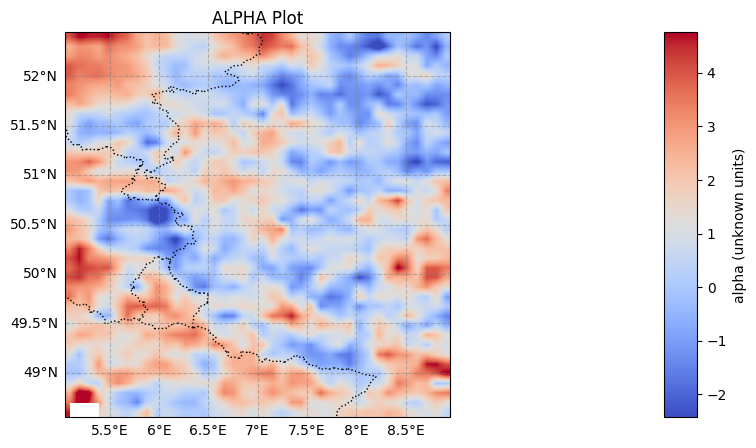

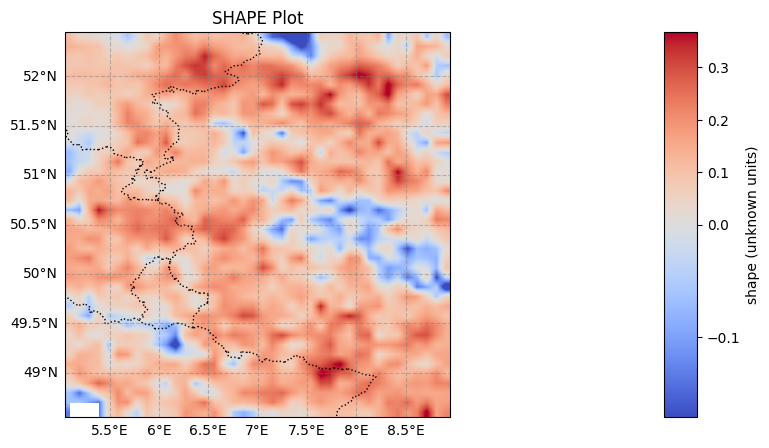

In [ ]:
global_min = EOBS_gev_grid_tr['alpha'].quantile(0.005)
global_max = EOBS_gev_grid_tr['alpha'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_grid_tr,variable='alpha',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = EOBS_gev_grid_tr['shape'].quantile(0.005)
global_max = EOBS_gev_grid_tr['shape'].quantile(0.995)
norm = colors.TwoSlopeNorm(vmin=global_min, vcenter=0, vmax=global_max)
plot_datacube(EOBS_gev_grid_tr,variable='shape',cmap='coolwarm',norm=norm,interpolation='bilinear')

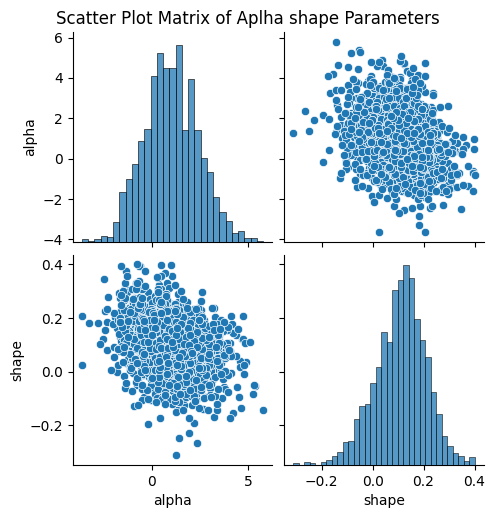

In [79]:
df = EOBS_gev_grid_tr.to_dataframe().reset_index()

sns.pairplot(df, vars=['alpha', 'shape'], kind='scatter')
plt.suptitle("Scatter Plot Matrix of Aplha shape Parameters", y=1.02)
plt.show()

## 📘 R : Library Import and Global Variable Definition

In this section, I import the necessary libraries 📦 for data manipulation and analysis in R. Additionally, I define global variables 🌐 (mostly path-related), which can be reused throughout the code for various locations or users.

We switch To R to fit the GEV now that we have our dataset(s) ready and built. We will use ismev for estimation and ggplot for plotting.

In [53]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ismev)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Loading required package: mgcv

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.



In [389]:
EOBS <- read.csv("c:\\Users\\bobel\\Downloads\\UCL_blockmax.csv")
#UCL <- read.csv("c:\\Users\\bobel\\OneDrive - Université de Namur\\Data\\Blockmax\\UCL_blockmax.csv")

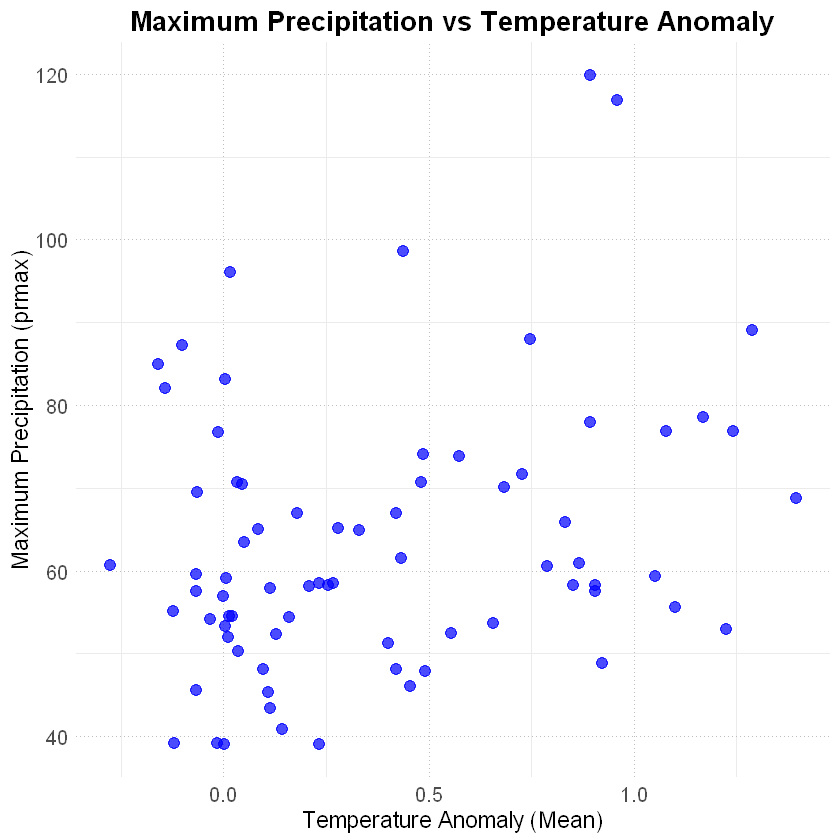

In [63]:
ggplot(EOBS, aes(x = tempanomalyMean, y = prmax)) +
  geom_point(color = 'blue', size = 3, alpha = 0.7) +
  labs(
    title = "Maximum Precipitation vs Temperature Anomaly",
    x = "Temperature Anomaly (Mean)",
    y = "Maximum Precipitation (prmax)"
  ) +
  theme_minimal() +  # A simple, clean theme for the plot
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    panel.grid.major = element_line(size = 0.5, linetype = "dotted", color = "gray")
  )

$conv
[1] 0

$nllh
[1] 307.7596

$mle
[1] 55.8991204 12.3197885  0.0250356

$se
[1] 1.60016258 1.16794858 0.08452555

If routine fails, try changing plotting interval


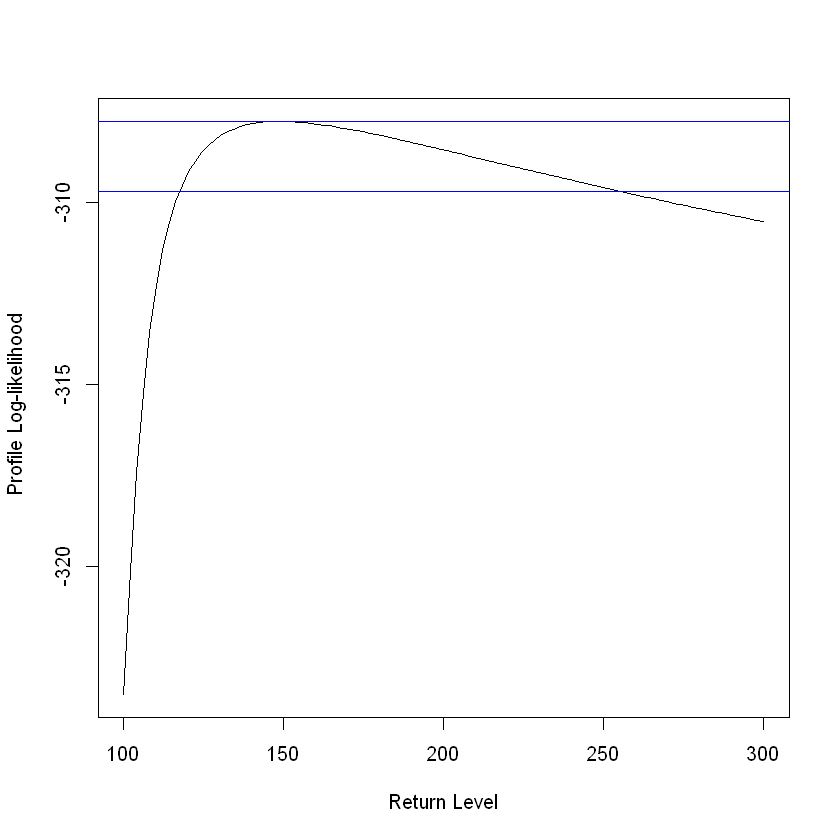

In [467]:
# Model 1 : Stationary GEV
fit_stationary = gev.fit(EOBS$prmax)
xlow <- 100 # Example lower bound
xup <- 300   # Example upper bound


gev.prof(z=fit_stationary, m = 1000,  xlow = xlow,xup = xup)
#mod test

$model
$model[[1]]
[1] 1

$model[[2]]
[1] 1

$model[[3]]
NULL


$link
[1] "c(identity, exp, identity)"

$conv
[1] 0

$nllh
[1] -41.79444

$mle
[1]  0.52192750  0.09860708 -2.17351432 -0.01720669  0.07511515

$se
[1] 0.0194769 0.0323092 0.1240485 0.2208087 0.1010294



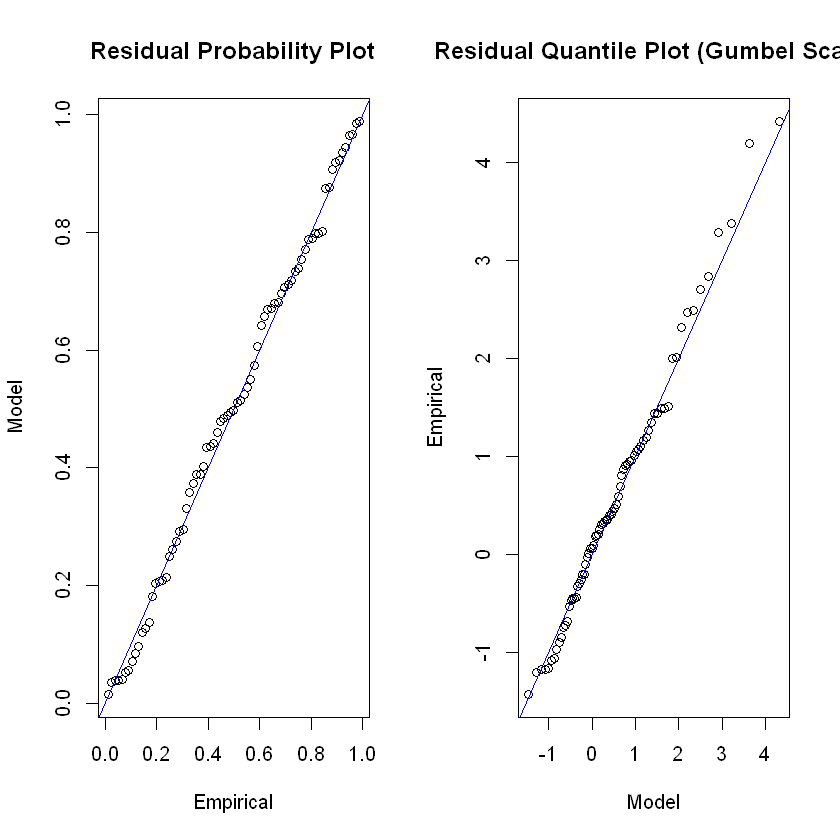

In [241]:
xdat <- EOBS$prmax
ydat <- as.matrix(EOBS$tempanomalyMean)  # Convert the covariate to a matrix format
xdat_positive <- xdat/100

fit_trend <- gev.fit(
  xdat = xdat_positive,
  ydat = ydat,
  mul = 1,
  sigl = 1,
  maxit = 100000,
  siglink = exp,
  method = "L-BFGS-B"    # No covariate for the shape parameter
)

gev.diag(fit_trend)

In [226]:
gev_statistical_summary_dynamic <- function(z=gev_fit_result,scale=NULL) {
  # Extracting elements from the GEV fit result
  nllh <- z$nllh
  mle <- z$mle
  se <- z$se
  conv <- z$conv
  n <- length(z$data)  # Number of observations
  k <- length(mle)  # Number of parameters
  
  # AIC and BIC calculation
  aic <- 2 * k + 2 * nllh
  bic <- log(n) * k + 2 * nllh
  
  # t-values (mle / se)
  t_values <- mle / se
  
  # p-values using normal approximation for large sample sizes
  p_values <- 2 * pnorm(-abs(t_values))  # Two-sided test
  
  # Create a significance level code
  significance_codes <- cut(p_values, 
                            breaks = c(-Inf, 0.001, 0.01, 0.05, 0.1, Inf), 
                            labels = c("***", "**", "*", ".", " "), 
                            right = FALSE)
  
  # Print the header
  if (is.null(scale)) {
    cat("GEV Fit Results\n")
  } else {
    c = paste("GEV Fit Results (Scale: ", scale, ")\n",sep = "")
    cat(c)
  }
  cat("=====================================\n")
  
  # Print negative log-likelihood
  cat("Negative Log-Likelihood:", round(nllh, 4), "\n")
  
  # Print AIC and BIC
  cat("AIC:", round(aic, 4), "\n")
  cat("BIC:", round(bic, 4), "\n")
  
  # Coefficient summary table
  cat("\nCoefficients:\n")
  
  # Dynamically label parameters
  param_names <- c("Shape")  # First parameter is always the shape
  
  # Add placeholders for additional parameters
  if (length(mle) > 1) {
    # If there are more than just the shape parameter, label the rest generically
    for (i in 2:length(mle)) {
      param_names <- c(param_names, paste0("par", i - 1))
    }
  }
  
  # Build a dataframe for results
  results <- data.frame(
    `Estimate` = mle,
    `StdError` = se,
    "t|Value" = t_values,
    `Prob.t` = p_values,
    `Codes` = significance_codes
  )

  return <- list(
    Model = deparse(substitute(z)),
    AIC = aic,
    BIC = bic,
    ParamQty = k,
    Scale = scale
  )
  rownames(results) <- param_names
  
  print(results, row.names = TRUE)
  
  # Convergence status
  cat("\nConvergence status (0 means successful):", conv, "\n")
  
  # Significance codes explanation
  cat("---\n")
  cat("Codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1\n")
  
  # Return the result invisibly for further use
  return
}

# Usage Example:
# Assuming `fit` is the result from calling gev.fit() on your data:
gev_statistical_summary_dynamic(z=fit_stationary,scale="max")


GEV Fit Results (Scale: max)
Negative Log-Likelihood: -51.1772 
AIC: -96.3543 
BIC: -89.4018 

Coefficients:
        Estimate   StdError    t.Value        Prob.t Codes
Shape 0.46658872 0.01335658 34.9332420 2.326750e-267   ***
par1  0.10283590 0.00974505 10.5526291  4.939520e-26   ***
par2  0.02498932 0.08451388  0.2956831  7.674721e-01      

Convergence status (0 means successful): 0 
---
Codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


$Model
[1] "fit_stationary"

$AIC
[1] -96.3543

$BIC
[1] -89.40184

$ParamQty
[1] 3

$Scale
[1] "max"

In [137]:
xdat <- EOBS$prmax
ydat <- as.matrix(EOBS$tempanomalyMean)  # Convert the covariate to a matrix format

fit_tra = gev.fit(xdat_positive, 
        ydat = ydat,  # Covariate matrix with T_prime (e.g., temperature)
        mul = 1,                 # Use the first column of ydat for mu (location)
        sigl = 1,                # Use the first column of ydat for sigma (scale)          # Shape parameter is constant (xi)          # Log link for mu
        mulink = exp  ,       # Log link for sigma   # Identity link for xi (constant shape)
        maxit = 10000)

gev.diag(fit_tra)

Error in solve.default(x$hessian): Lapack routine dgesv: system is exactly singular: U[1,1] = 0
Traceback:

1. gev.fit(xdat_positive, ydat = ydat, mul = 1, sigl = 1, mulink = exp, 
 .     maxit = 10000)
2. solve(x$hessian)
3. solve.default(x$hessian)


Error: ERROR